## **Import Libraries**

In [1]:
# %pip install mlxtend --upgrade
# %pip install pyLDAvis
import math
import pandas as pd 
import numpy as np
from numpy import concatenate
import re
from urllib import request
from pprint import pprint 

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import silhouette_score ,silhouette_samples
import matplotlib.cm as cm
from sklearn.utils import shuffle
from sklearn.cluster import KMeans 
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.decomposition  import PCA
from sklearn.metrics import cohen_kappa_score
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics.pairwise import euclidean_distances

import scipy.cluster.hierarchy as shc
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# nltk 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ginsim
import gensim
import gensim.corpora as corpora
import gensim.utils as simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
import gensim.downloader as api
import spacy
import scipy

# Plotting tools

# import pyLDAvis.gensim_models as genisvis
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
nltk.download("stopwords")
nltk.download("wordnet")
print(stopwords.words('english'))
import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'ov

True

## **Preprocessing**

In [3]:
def removes_stopwords(texts):
  stop_words = stopwords.words('english')
  return [word for word in gensim.utils.simple_preprocess(str(texts)) if word not in stop_words]


def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count = 5, threshold = 100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count = 5, threshold = 100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold = 100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return [trigram_mod[bigram_mod[doc]] for doc in texts]    

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [4]:
#  1- Politics Title: Democracy In America   Author: Alexis de Toqueville
url1 = "https://www.gutenberg.org/cache/epub/815/pg815.txt" 
#  2- Law  Title: The Common Law  Author: Edward Gibbon
url2 = "https://www.gutenberg.org/cache/epub/2449/pg2449.txt"   
#  3- Music   Title: The Lighter Classics in Music   Author: David Ewen
url3 = "https://www.gutenberg.org/cache/epub/66346/pg66346.txt"   
#  4- Food     Title: Food and Flavor    Author: Henry Theophilus
url4 = "https://www.gutenberg.org/files/61719/61719-0.txt"   
#  5- Computer and Tech  Title: The Jargon File  Author:  Various
url5 = "https://www.gutenberg.org/cache/epub/38/pg38.txt"       

urls = [url1 ,url2 ,url3, url4 ,url5]

Books_names = ["Democracy In America" ,
               "The Common Law" ,
               "The Lighter Classics in Music"  ,
               "Food and Flavor" ,
               "The Jargon File"]

# Books_label_num = [ '0' ,'1' ,'2', '3' ,'4']
Books_label = ['a', 'b', 'c', 'd', 'e']

Authors = ["Alexis de Toqueville" ,
           "Oliver Wendell Holmes" ,
           "David Ewen" ,
           "Henry Theophilus" ,
           "Various"]

book = []
r = []
bg = []

for U  in urls :
  response = request.urlopen(U)
  raw = response.read().decode('utf8')
  text= re.findall(r"[a-zA-Z]{3,}", raw)
  r.append(removes_stopwords(text))
bi_grams = make_bigrams(r)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(bi_grams,
                                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
texts = data_lemmatized

# make sure that all lists contain 100 word 
Books_contents_100 = []               
for i in texts:
    l = i[0:(math.floor(len(i)/150)) * 150]
    Books_contents_100.append(l)

# combine all lists in one dataframe 
data = pd.DataFrame()
for i in range(len(Books_contents_100)):
    dic = {}
    lis =  [Books_contents_100[i][x:x+150] for x in range(0, len(Books_contents_100[i]), 150)]
    dic['index']= i  # refer to the number of the book 
    dic['Authors']= Authors[i]
    dic['title']= Books_names[i] # refer to the book name
    dic['label'] = Books_label[i]
    dic['a150_Words'] = lis # the partition of 100 words
    df_0 = pd.DataFrame(dic)
    for i in range(len(df_0)):
        df_0["a150_Words"][i] = " ".join(df_0["a150_Words"][i])
    df = df_0[:200]
    data = data.append(df)
    
data = shuffle(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
data.head()           

,index,Authors,title,label,a150_Words
64,1,Oliver Wendell Holmes,The Common Law,b,say defendant intent essential liability absen...
153,0,Alexis de Toqueville,Democracy In America,a,weaken destroy see last hypothesis remain stat...
18,2,David Ewen,The Lighter Classics in Music,c,rhythm contredanse particularly famous melody ...
2,0,Alexis de Toqueville,Democracy In America,a,generation mean man could act man land propert...
143,0,Alexis de Toqueville,Democracy In America,a,entertain real intention obeying central_gover...


In [6]:
da = data.iloc[109, 4]
len(da.split())

150

## **Text Transformation**

### (1) Bag of Words

In [7]:
count_Vec= CountVectorizer()
bow = count_Vec.fit_transform(data['a150_Words'])
X_bow = bow.toarray()
bow_df = pd.DataFrame(bow.toarray(), columns=count_Vec.get_feature_names())
bow_df

,abandon,abandoning,abash,abbess,abbreviate,abbreviation,abdicate,abduct,abend,abeyance,abhor,ability,abject,able,ably,abnormal,abode,abolish,abolishe,abolition,abominable,aboriginal,abort,abound,abridge,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absolution,absorb,absorption,absque,abstain,abstract,abstraction,absurd,...,xylophone,yaba,yard,year,year_book,yearly,yearn,years_ago,yeat,yellow,yellowish,yesterday,yesterthought,yet,yiddish,yield,yoke,yolk,yoo,young,youth,youthful,yradi,yucky,yuppie,yyyy,zeal,zealot,zealous,zealously,zed,zee,zeltube,zephyr,zeroth,zigeunerkind,zion,zip,zoo,zwieback
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### (2) TFIDF

In [8]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(data['a150_Words'])
X_tfidf = tfidf.toarray()
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
tfidf_df

,abandon,abandoning,abash,abbess,abbreviate,abbreviation,abdicate,abduct,abend,abeyance,abhor,ability,abject,able,ably,abnormal,abode,abolish,abolishe,abolition,abominable,aboriginal,abort,abound,abridge,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absolution,absorb,absorption,absque,abstain,abstract,abstraction,absurd,...,xylophone,yaba,yard,year,year_book,yearly,yearn,years_ago,yeat,yellow,yellowish,yesterday,yesterthought,yet,yiddish,yield,yoke,yolk,yoo,young,youth,youthful,yradi,yucky,yuppie,yyyy,zeal,zealot,zealous,zealously,zed,zee,zeltube,zephyr,zeroth,zigeunerkind,zion,zip,zoo,zwieback
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.068358,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.16029,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.076173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.032585,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.038507,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083292,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.117014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.060811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### (3) Word2Vec

In [9]:
# split our partitions to list of words
sent = data['a150_Words'].tolist()
splitted_sent = [sen.split() for sen in sent]
print(len(splitted_sent))

1000


In [10]:
print(splitted_sent[0])

['say', 'defendant', 'intent', 'essential', 'liability', 'absence', 'would', 'deprive', 'act', 'character', 'trespass', 'ought', 'therefore', 'admissible', 'general', 'issue', 'perfectly', 'well', 'settle', 'common', 'law', 'guilty', 'denie', 'act', 'next', 'come', 'argument', 'authority', 'begin', 'early', 'important', 'case', 'clausum', 'defendant', 'plead', 'own', 'adjoining', 'land', 'thorn', 'hedge', 'cut', 'thorn', 'fall', 'defendant', 'go', 'quickly', 'take', 'trespass', 'complain', 'demurrer', 'judgment', 'give', 'plaintiff', 'plaintiff', 'counsel', 'put', 'case', 'often', 'repeat', 'fairfax', 'say', 'diversity', 'result', 'felony', 'one', 'result', 'trespass', 'cut', 'tree', 'bough', 'fall', 'man', 'case', 'shall', 'action', 'also', 'sir', 'shoot', 'butts', 'bow', 'shake', 'hand', 'say', 'wound', 'shoot', 'shall', 'good', 'action', 'trespass', 'yet', 'shoot', 'lawful', 'wrong', 'receive', 'counsel', 'state', 'whole', 'doctrine', 'use', 'equally', 'familiar', 'illustration', 't

In [11]:
# load a pre-trained word2vec-google model
#wv = api.load('word2vec-google-news-300')

In [12]:
# build our word2vec model
word_2_vec_model = Word2Vec(splitted_sent,
                            min_count= 1,
                            size= 150,
                            workers=6, 
                            window= 3,
                            sg= 1)
# save trained model
word_2_vec_model.save("word2vec.model")

In [13]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding
    
    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(splitted_sent, model=word_2_vec_model)
X_emb = np.array(vectorized_docs)
len(vectorized_docs), len(vectorized_docs[0])

(1000, 150)

In [14]:
print(vectorized_docs[0])

[ 9.87958759e-02 -1.04073495e-01 -8.14793538e-03  1.83155790e-01
 -1.45145720e-02  3.11223656e-01  2.41158098e-01  8.24048892e-02
  3.92921299e-01  2.50126630e-01 -1.97511241e-02 -2.11063936e-01
  2.31073484e-01  8.70851241e-03  1.84487477e-01 -1.00874625e-01
  1.89070329e-02 -1.33475177e-02 -2.81215936e-01 -5.97139858e-02
  1.76263213e-01 -4.07738127e-02  1.88167375e-02  2.79141009e-01
  6.03018366e-02 -3.43036838e-02 -7.63209760e-02 -1.01129912e-01
 -1.45730600e-01  1.79951251e-01 -6.63379356e-02  1.45315036e-01
  1.50478268e-02  1.63734898e-01 -1.21370725e-01 -1.16134854e-02
  5.64714484e-02  6.50946647e-02 -9.34554338e-02  2.14741230e-02
  1.33028448e-01 -8.41423124e-02  3.63324594e-04 -1.74678236e-01
  1.46922499e-01 -1.15566470e-01 -3.96707237e-01 -6.27103522e-02
 -1.09130554e-01 -3.68499085e-02 -2.24903543e-02 -3.07897002e-01
  1.12159297e-01 -7.18080848e-02  6.99578691e-03  1.85139775e-01
 -1.33498143e-02  3.25341612e-01 -1.16472535e-01  2.85920817e-02
 -2.18275294e-01  5.42268

### (4) LDA

In [15]:
# create dictionary
dictionary = corpora.Dictionary(data['a150_Words'].str.split())
#Term document frequency
corpus = [dictionary.doc2bow(text) for text in data['a150_Words'].str.split()]

# 50 Topic
lda_model_150 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 150,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100, 
                                           passes = 10, 
                                           alpha = 'auto',
                                           per_word_topics = True)
pred_150 = lda_model_150.inference(corpus)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


## LDA as Topic Modelling

In [15]:
# create dictionary
dictionary = corpora.Dictionary(data['a150_Words'].str.split())
#Term document frequency
corpus = [dictionary.doc2bow(text) for text in data['a150_Words'].str.split()]

# 50 Topic
lda_model_5 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 5,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100, 
                                           passes = 10, 
                                           alpha = 'auto',
                                           per_word_topics = True)
pred_5 = lda_model_5.inference(corpus)

In [ ]:
# %pip install pyLDAvis

In [16]:
import pyLDAvis
import pyLDAvis.gensim_models as genisvis
pyLDAvis.enable_notebook()
vis = genisvis.prepare(lda_model_5, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.138073  0.009137       1        1  24.944344
3     -0.239933 -0.114030       2        1  19.595891
2     -0.042872  0.173338       3        1  18.762925
4      0.006932  0.089845       4        1  18.535500
1      0.137801 -0.158290       5        1  18.161340, topic_info=           Term        Freq       Total Category  logprob  loglift
261       music  553.000000  553.000000  Default  30.0000  30.0000
57          law  910.000000  910.000000  Default  29.0000  29.0000
17         case  545.000000  545.000000  Default  28.0000  28.0000
85        state  471.000000  471.000000  Default  27.0000  27.0000
254      melody  300.000000  300.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
295        time  103.761877  559.898008   Topic5  -5.5704   0.0202
147        form   89.705000  310.312985   Topic5  -5.7160   0.4648
1018  principle   81.755709  226.343081   Topic5  -5.8088   0.6876
196         see   90.149407  621.037305   Topic5  -5.7110  -0.2240
98        would   80.200359  591.478361   Topic5  -5.8280  -0.2922

[329 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1         1  0.789778     act
1         2  0.133861     act
1         5  0.073623     act
2         1  0.837283  action
2         2  0.018606  action
...     ...       ...     ...
307       1  0.080581    year
307       2  0.577496    year
307       3  0.030218    year
307       4  0.208167    year
307       5  0.104084    year

[571 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 5, 2])

In [18]:
lda_df = pd.DataFrame(list(pred_5[0]), columns=['1', '2','3','4', '5'])
lda_df.head()

,1,2,3,4,5
0,144.534653,0.173362,0.129806,2.626913,3.327265
1,28.769848,121.636551,0.129691,0.126669,0.129245
2,0.242855,0.173684,0.129883,150.116455,0.129108
3,16.037539,127.659180,6.838893,0.126916,0.129460
4,32.719364,107.912415,9.904254,0.126689,0.129272


In [26]:
lda_df['res'] = lda_df.idxmax(axis = 1)

In [28]:
lda_df

,1,2,3,4,5,res
0,144.534653,0.173362,0.129806,2.626913,3.327265,1
1,28.769848,121.636551,0.129691,0.126669,0.129245,2
2,0.242855,0.173684,0.129883,150.116455,0.129108,4
3,16.037539,127.659180,6.838893,0.126916,0.129460,2
4,32.719364,107.912415,9.904254,0.126689,0.129272,2
...,...,...,...,...,...,...
995,148.197479,0.173541,0.129650,0.126633,2.164699,1
996,144.824417,0.173985,2.203517,3.460966,0.129127,1
997,0.242592,0.173125,0.129624,1.598586,148.648071,5
998,0.243078,10.093127,0.129911,137.837311,2.488584,4


In [27]:
pred_5

(array([[1.4453465e+02, 1.7336175e-01, 1.2980571e-01, 2.6269133e+00,
         3.3272648e+00],
        [2.8769848e+01, 1.2163655e+02, 1.2969096e-01, 1.2666915e-01,
         1.2924527e-01],
        [2.4285458e-01, 1.7368379e-01, 1.2988283e-01, 1.5011646e+02,
         1.2910847e-01],
        ...,
        [2.4259187e-01, 1.7312452e-01, 1.2962374e-01, 1.5985861e+00,
         1.4864807e+02],
        [2.4307771e-01, 1.0093127e+01, 1.2991068e-01, 1.3783731e+02,
         2.4885840e+00],
        [3.8187901e+01, 1.1221854e+02, 1.2969953e-01, 1.2666869e-01,
         1.2918499e-01]], dtype=float32), None)

## **Models**

### **(1) K-Means**

In [31]:
def build_kMeans(clusters, X_data):
  kmeans_model= KMeans(n_clusters= clusters, init='k-means++', random_state=0)
  y_pred = kmeans_model.fit_predict(X_data)
  return kmeans_model, y_pred

In [32]:
# method to reduce dimension of data to visualize it
def data_with_tsna(desired_data):
  tsna = TSNE(n_components= 2, random_state= 42)
  data_tsna = tsna.fit_transform(desired_data) 
  return data_tsna

In [33]:
# # method to reduce dimension of the data with keeping most of data information
# def data_with_pca(desired_data):
#   pca = PCA(n_components= 0.95, random_state= 42)
#   data_pca = pca.fit_transform(desired_data) 
#   return data_pca

#### (1.1) K-means With BOW

In [ ]:
bow_data = data_with_tsna(X_bow)
# bow_data_pca = data_with_pca(X_bow)
bow_kmeans, bow_kmeans_pred = build_kMeans(5,bow_data)

In [ ]:
bow_kmeans.cluster_centers_.argsort()[:, ::-1]

array([[1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1]])

#### (1.2) K-Means with TFIDF

In [ ]:
tfidf_data = data_with_tsna(X_tfidf)
# tfidf_data_pca = data_with_pca(X_tfidf)
tfidf_kmeans, tfidf_kmeans_pred = build_kMeans(5,tfidf_data)

#### (1.3) K-Means with Word2Vec

In [ ]:
emb_data = data_with_tsna(X_emb)
# emb_data_pca = data_with_pca(X_emb)
emb_kmeans, emb_kmeans_pred = build_kMeans(5,emb_data)

#### (1.4) K-Means with LDA

In [ ]:
lda_data = data_with_tsna(pred_150[0])
# lda_data_pca = data_with_pca(pred_150[0])
lda_kmeans, lda_kmeans_pred = build_kMeans(5, lda_data)

### **(2) Expectation Maximization  (EM)**

In [ ]:
def build_em(clusters, X_data):
  #pca = PCA(n_components= 0.99)
  #new_X = pca.fit_transform(X_data)
  #print("shape before using PCA : ",X_data.shape)
  #print("shape after using PCA : ",new_X.shape)
  #print(f'the new dimension consists of {new_X.shape[1]} that represent 99% of data info '.format(new_X.shape[1]))
  
  gmm_model= GaussianMixture(n_components=clusters ,
                             covariance_type= "spherical" ,
                             n_init= 10 )
  
  y_pred= gmm_model.fit_predict(X_data)
  gmm_probability = gmm_model.predict_proba(X_data)
  return gmm_model, y_pred, gmm_probability 

#### (2.1) EM with BOW

In [ ]:
bow_em, bow_em_pred, bow_em_proba = build_em(5,bow_data)

#### (2.2) EM With TFIDF

In [ ]:
tfidf_em, tfidf_em_pred, tfidf_em_proba = build_em(5,tfidf_data)

#### (2.3) EM with Word2Vec

In [ ]:
emb_em, emb_em_pred, emb_em_proba = build_em(5,emb_data)

#### (2.4) EM with LDA

In [ ]:
lda_em, lda_em_pred, lda_em_proba = build_em(5, lda_data)

### **(3) Hierarchical clustering (Agglomerative)**

In [ ]:
def build_hierarchical_cluster(clusters, X_data, title):
  # plot dendogram
  plt.figure(figsize=(10, 7)) 
  plt.title(title) 


  dend= shc.dendrogram(shc.linkage(X_data, method='ward'))
  agg_model= AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='ward')  
  y_pred= agg_model.fit_predict(X_data)
  return agg_model, y_pred

#### (3.1) Hierarchical clustering With BOW

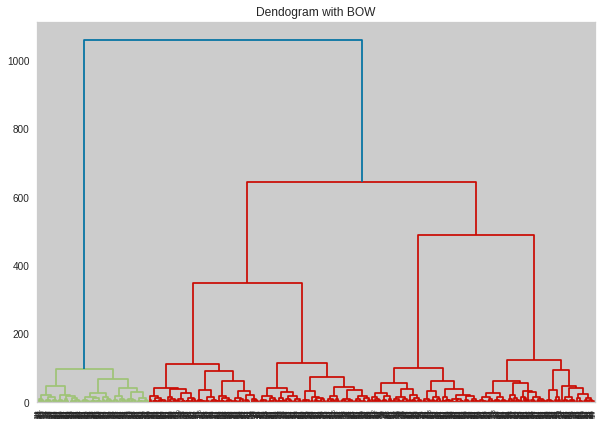

In [ ]:
bow_agg, bow_agg_pred= build_hierarchical_cluster(5, bow_data,"Dendogram with BOW")

#### (3.2) Hierarchical clustering With TFIDF

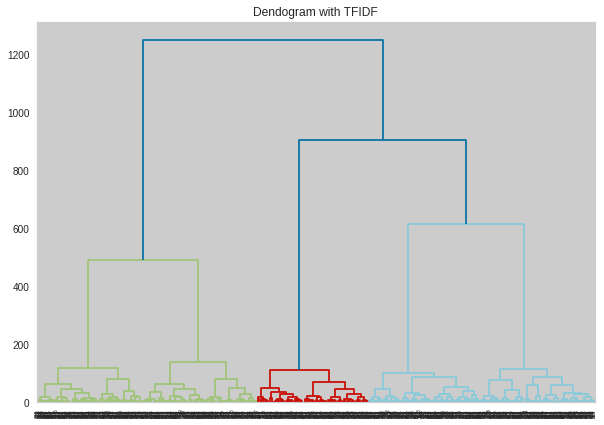

In [ ]:
tfidf_agg, tfidf_agg_pred= build_hierarchical_cluster(5, tfidf_data,"Dendogram with TFIDF")

#### (3.3) Hierarchical clustering With Word2Vec

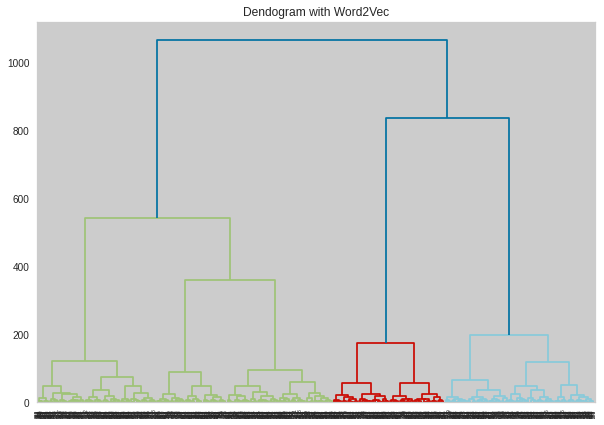

In [ ]:
emb_agg, emb_agg_pred= build_hierarchical_cluster(5, emb_data,"Dendogram with Word2Vec")

#### (3.4) Hierarchical clustering With LDA

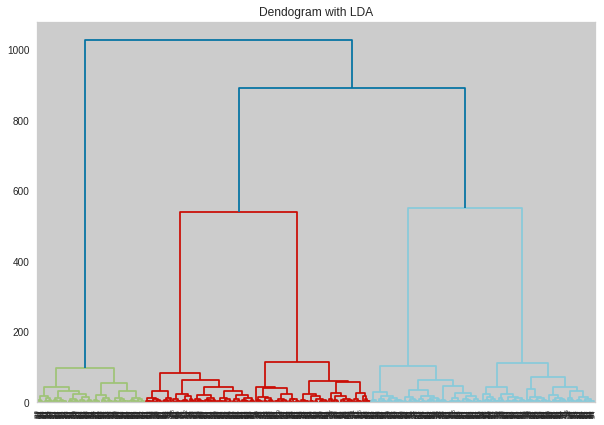

In [ ]:
lda_agg, lda_agg_pred= build_hierarchical_cluster(5, lda_data, "Dendogram with LDA")

## **Evaluation**

### **(1) Kapaa**

#### (1.1) Kappa with K-means

In [30]:
data['index']

64     1
153    0
18     2
2      0
143    0
      ..
146    1
55     1
153    3
64     2
190    0
Name: index, Length: 1000, dtype: int64

In [44]:
lda_topic_pred = lda_df.loc[:,'res'].values
lda_topic_pred = lda_topic_pred.astype(int)
lda_topic_pred

array([1, 2, 4, 2, 2, 3, 5, 2, 4, 3, 3, 1, 2, 3, 2, 5, 5, 5, 4, 5, 5, 4,
       5, 1, 5, 3, 4, 5, 2, 4, 2, 1, 5, 1, 3, 4, 3, 2, 2, 2, 1, 4, 1, 4,
       2, 2, 4, 2, 5, 3, 4, 5, 5, 2, 1, 4, 4, 1, 1, 2, 1, 2, 1, 4, 1, 4,
       1, 4, 3, 3, 3, 5, 2, 5, 3, 3, 2, 2, 4, 4, 5, 5, 2, 3, 5, 1, 1, 3,
       1, 1, 4, 1, 3, 5, 4, 4, 3, 2, 1, 4, 5, 3, 3, 2, 1, 2, 5, 3, 1, 2,
       1, 3, 4, 4, 5, 1, 3, 1, 4, 1, 2, 2, 5, 5, 5, 5, 1, 5, 3, 5, 3, 3,
       3, 4, 1, 1, 5, 1, 1, 3, 1, 1, 4, 5, 1, 2, 2, 2, 2, 3, 2, 5, 4, 1,
       1, 3, 2, 4, 3, 5, 3, 1, 1, 2, 3, 5, 1, 2, 3, 3, 4, 1, 1, 2, 2, 4,
       2, 5, 2, 2, 1, 5, 1, 5, 1, 3, 3, 5, 1, 1, 1, 2, 4, 1, 1, 1, 1, 4,
       4, 3, 5, 4, 1, 5, 5, 1, 1, 2, 5, 2, 5, 1, 4, 2, 1, 5, 5, 4, 4, 3,
       3, 2, 3, 2, 4, 4, 5, 3, 2, 4, 3, 5, 5, 3, 3, 4, 2, 1, 5, 2, 1, 1,
       4, 4, 1, 3, 4, 3, 1, 2, 5, 1, 5, 5, 5, 2, 5, 1, 2, 1, 4, 1, 3, 3,
       4, 1, 1, 4, 1, 3, 4, 4, 2, 1, 1, 2, 2, 3, 2, 5, 2, 4, 2, 2, 1, 1,
       3, 5, 2, 2, 2, 3, 4, 5, 3, 2, 2, 2, 3, 4, 4,

In [ ]:
print("Kappa Score of K-means With BOW           :  {:.4f}".format(cohen_kappa_score(data['index'],bow_kmeans_pred)))
print("Kappa Score of K-means With TFIDF         :  {:.4f}".format(cohen_kappa_score(data['index'],tfidf_kmeans_pred)))
print("Kappa Score of K-means With Word2Vec      :  {:.4f}".format(cohen_kappa_score(data['index'],emb_kmeans_pred)))
print("Kappa Score of K-means With LDA           :  {:.4f}".format(cohen_kappa_score(data['index'],lda_kmeans_pred)))

Kappa Score of K-means With BOW           :  -0.2475
Kappa Score of K-means With TFIDF         :  -0.2425
Kappa Score of K-means With Word2Vec      :  0.2375
Kappa Score of K-means With LDA           :  -0.0012


In [46]:
print("Kappa Score of LDA as Topic Modeling           :  {:.4f}".format(cohen_kappa_score(data['index'], lda_topic_pred)))

Kappa Score of LDA as Topic Modeling           :  0.0467


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:592: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


#### (1.2) Kappa with EM

In [ ]:
print("Kappa Score of EM With BOW                :  {:.4f}".format(cohen_kappa_score(data['index'],bow_em_pred)))
print("Kappa Score of EM With TFIDF              :  {:.4f}".format(cohen_kappa_score(data['index'],tfidf_em_pred)))
print("Kappa Score of EM With Word2Vec           :  {:.4f}".format(cohen_kappa_score(data['index'],emb_em_pred)))
print("Kappa Score of EM With LDA                :  {:.4f}".format(cohen_kappa_score(data['index'],lda_em_pred)))

Kappa Score of EM With BOW                :  -0.0025
Kappa Score of EM With TFIDF              :  0.5000
Kappa Score of EM With Word2Vec           :  -0.2375
Kappa Score of EM With LDA                :  0.2450


#### (1.3) Kappa with Hierarchical clustering

In [ ]:
print("Kappa Score of Hierarchical clustering With BOW                :  {:.4f}".format(cohen_kappa_score(data['index'],bow_agg_pred)))
print("Kappa Score of Hierarchical clustering With TFIDF              :  {:.4f}".format(cohen_kappa_score(data['index'],tfidf_agg_pred)))
print("Kappa Score of Hierarchical clustering With Word2Vec           :  {:.4f}".format(cohen_kappa_score(data['index'],emb_agg_pred)))
print("Kappa Score of Hierarchical clustering With LDA                :  {:.4f}".format(cohen_kappa_score(data['index'],lda_agg_pred)))

Kappa Score of Hierarchical clustering With BOW                :  0.2425
Kappa Score of Hierarchical clustering With TFIDF              :  0.0038
Kappa Score of Hierarchical clustering With Word2Vec           :  0.3325
Kappa Score of Hierarchical clustering With LDA                :  0.0012


### **(2) Silhouette**

In [ ]:
def visualize_silhouette_kmeans(X_data, model, title):
  # Instantiate the clustering model and visualizer
  visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
  # Fit the data to the visualizer
  visualizer.fit(X_data)
  plt.title("Silhouette Score of K-means With " + title)

#### (2.1) Silhouette with K-means

In [ ]:
print("Silhouette Score of K-means With BOW      :  {:.4f}".format(silhouette_score(bow_data, bow_kmeans_pred)))
print("Silhouette Score of K-means With TFIDF    :  {:.4f}".format(silhouette_score(tfidf_data, tfidf_kmeans_pred)))
print("Silhouette Score of K-means With Word2Vec :  {:.4f}".format(silhouette_score(emb_data, emb_kmeans_pred)))
print("Silhouette Score of K-means With LDA      :  {:.4f}".format(silhouette_score(lda_data, lda_kmeans_pred)))

Silhouette Score of K-means With BOW      :  0.6145
Silhouette Score of K-means With TFIDF    :  0.6899
Silhouette Score of K-means With Word2Vec :  0.6225
Silhouette Score of K-means With LDA      :  0.7460


#### Silhouette with K-means and BOW

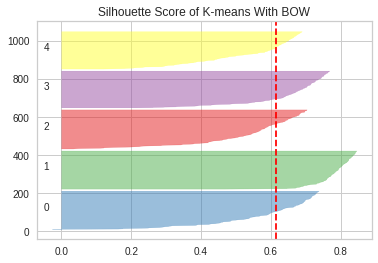

In [ ]:
visualize_silhouette_kmeans(bow_data, bow_kmeans,"BOW");

#### Silhouette with K-means and TFIDF

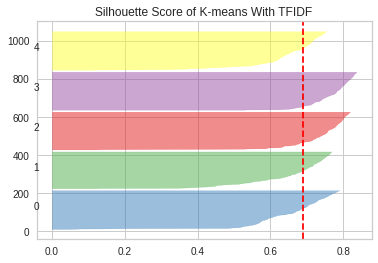

In [ ]:
visualize_silhouette_kmeans(tfidf_data, tfidf_kmeans, "TFIDF");

#### Silhouette with K-means and word embedding

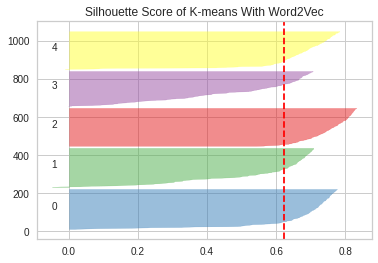

In [ ]:
visualize_silhouette_kmeans(emb_data, emb_kmeans, "Word2Vec");

#### Silhouette with K-means and LDA

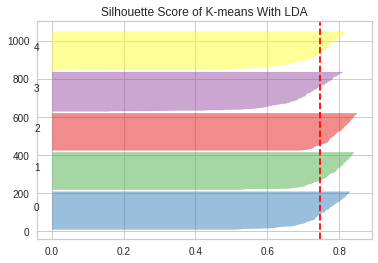

In [ ]:
visualize_silhouette_kmeans(lda_data, lda_kmeans,"LDA");

#### (2.2) Silhouette with EM

In [ ]:
print("Silhouette Score of EM With BOW      :  {:.4f}".format(silhouette_score(bow_data, bow_em_pred)))
print("Silhouette Score of EM With TFIDF    :  {:.4f}".format(silhouette_score(tfidf_data, tfidf_em_pred)))
print("Silhouette Score of EM With Word2Vec :  {:.4f}".format(silhouette_score(emb_data, emb_em_pred)))
print("Silhouette Score of EM With LDA      :  {:.4f}".format(silhouette_score(lda_data, lda_em_pred)))

Silhouette Score of EM With BOW      :  0.6143
Silhouette Score of EM With TFIDF    :  0.6899
Silhouette Score of EM With Word2Vec :  0.6223
Silhouette Score of EM With LDA      :  0.7460


#### (2.3) Silhouette with Hierarchical clustering

In [ ]:
print("Silhouette Score of Hierarchical clustering With BOW      :  {:.4f}".format(silhouette_score(bow_data, bow_agg_pred)))
print("Silhouette Score of Hierarchical clustering With TFIDF    :  {:.4f}".format(silhouette_score(tfidf_data, tfidf_agg_pred)))
print("Silhouette Score of Hierarchical clustering With Word2Vec :  {:.4f}".format(silhouette_score(emb_data, emb_agg_pred)))
print("Silhouette Score of Hierarchical clustering With LDA      :  {:.4f}".format(silhouette_score(lda_data, lda_agg_pred)))

Silhouette Score of Hierarchical clustering With BOW      :  0.6130
Silhouette Score of Hierarchical clustering With TFIDF    :  0.6897
Silhouette Score of Hierarchical clustering With Word2Vec :  0.6131
Silhouette Score of Hierarchical clustering With LDA      :  0.7460


### **(4) Consistency**

In [ ]:
def calc_consistency(kmeans_model, data, pred):
  distance_between_clusters = euclidean_distances(kmeans_model.cluster_centers_)

  # get distance between each cluster and all clusters
  tri_dists = distance_between_clusters[np.triu_indices(5, 1)] 
  
  # get max dist, mean dist, and min dist for each cluster distances 
  max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min() 
  
  # get centroid of each cluster
  centroids = kmeans_model.cluster_centers_

  distances = []
  # get distance between each datapoint and each cluster centrod
  for i, (cx, cy) in enumerate(centroids): 
    mean_distance = [np.sqrt((x-cx)**2+(y-cy)**2) for (x, y) in data[pred == i]] 
    distances.append(mean_distance)

  # get the mean distance of distances between datapoints and each cluster centroids 
  mean_lst = []
  for i in range(len(distances)):
    mean_lst.append(np.mean(distances[i])) 
  mean_lst   

  return distance_between_clusters, distances, mean_lst

In [ ]:
def print_consistency(dist_clusters, mean_dis_within_cluster):
  print("Distance between clusters: \n")
  print(dist_clusters, "\n")
  print("Distance within clusters: \n")
  print(mean_dis_within_cluster)


#### (3.1) Consistency with K-means BOW

In [ ]:
len(dists_bow[0])

202

In [ ]:
dist_clusters_bow, dists_bow, mean_dis_within_cluster_bow = calc_consistency(bow_kmeans, bow_data, bow_kmeans_pred)
print_consistency(dist_clusters_bow, mean_dis_within_cluster_bow)

Distance between clusters: 

[[ 0.       44.21436  31.556625 34.854126 36.464436]
 [44.21436   0.       69.81316  51.003384 80.6116  ]
 [31.556625 69.81316   0.       30.390821 24.660635]
 [34.854126 51.003384 30.390821  0.       52.981018]
 [36.464436 80.6116   24.660635 52.981018  0.      ]] 

Distance within clusters: 

[8.711841547667296, 7.0532440661014375, 7.984487205928249, 7.475714515854125, 8.602540993267349]


#### (3.2) Consistency with K-means TFIDF

In [ ]:
dist_clusters_tfidf, dists_tfidf, mean_dis_within_cluster_tfidf = calc_consistency(tfidf_kmeans, tfidf_data, tfidf_kmeans_pred)
print_consistency(dist_clusters_tfidf, mean_dis_within_cluster_tfidf)

Distance between clusters: 

[[ 0.       42.873154 43.2617   46.53656  45.677776]
 [42.873154  0.       73.90072  83.75615  34.96739 ]
 [43.2617   73.90072   0.       70.22237  52.184315]
 [46.53656  83.75615  70.22237   0.       92.11277 ]
 [45.677776 34.96739  52.184315 92.11277   0.      ]] 

Distance within clusters: 

[9.119577478908836, 8.729626534037928, 8.11938307878348, 7.8455856902831735, 9.185718282953541]


#### (3.3) Consistency with K-means Word2Vec

In [ ]:
dist_clusters_emb, dists_emb, mean_dis_within_cluster_emb = calc_consistency(emb_kmeans, emb_data, emb_kmeans_pred)
print_consistency(dist_clusters_emb, mean_dis_within_cluster_emb)

Distance between clusters: 

[[ 0.       68.70043  53.040077 47.907665 31.76853 ]
 [68.70043   0.       55.262897 26.876385 61.176937]
 [53.040077 55.262897  0.       57.440575 72.437325]
 [47.907665 26.876385 57.440575  0.       34.41762 ]
 [31.76853  61.176937 72.437325 34.41762   0.      ]] 

Distance within clusters: 

[7.4807277395387315, 8.565790150094866, 9.166491326111348, 8.387921221478758, 7.100946513767173]


#### (3.4) Consistency with K-means LDA

In [ ]:
dist_clusters_lda, dists_lda, mean_dis_within_cluster_lda = calc_consistency(lda_kmeans, lda_data, lda_kmeans_pred)
print_consistency(dist_clusters_lda, mean_dis_within_cluster_lda)

Distance between clusters: 

[[ 0.       72.34621  56.660168 40.96203  38.92072 ]
 [72.34621   0.       75.957565 38.045193 48.686737]
 [56.660168 75.957565  0.       42.340923 78.92048 ]
 [40.96203  38.045193 42.340923  0.       41.03282 ]
 [38.92072  48.686737 78.92048  41.03282   0.      ]] 

Distance within clusters: 

[6.825624671554153, 6.274231906761432, 6.581055181530391, 7.416564546409946, 7.432126751130571]


### **(4) Coherence With LDA**

In [ ]:
# Compute Perplexity
# a measure of how good the model is. lower the better.
print('\nPerplexity score: ', lda_model_150.log_perplexity(corpus))  

cm_cv = CoherenceModel(model= lda_model_150, texts= splitted_sent, dictionary=dictionary, coherence='c_v')
cm_umass = CoherenceModel(model= lda_model_150, texts= splitted_sent, dictionary=dictionary, coherence='u_mass')
coherence_cv = round(cm_cv.get_coherence(), 4)  # get coherence value
coherence_umass = round(cm_umass.get_coherence(), 4)  # get coherence value
print("\nCoherence score With LDA using c_v: {}".format(coherence_cv))
print("\nCoherence score With LDA using u_mass: {}".format(coherence_umass))



Perplexity score:  -32.012309265112876

Coherence score With LDA using c_v: 0.4021

Coherence score With LDA using u_mass: -8.4388


In [ ]:
from gensim.models import CoherenceModel

In [ ]:
# Compute Perplexity
# a measure of how good the model is. lower the better.
print('\nPerplexity score: ', lda_model_5.log_perplexity(corpus))  

cm_cv = CoherenceModel(model= lda_model_5, texts= splitted_sent, dictionary=dictionary, coherence='c_v')
cm_umass = CoherenceModel(model= lda_model_5, texts= splitted_sent, dictionary=dictionary, coherence='u_mass')
coherence_cv = round(cm_cv.get_coherence(), 4)  # get coherence value
coherence_umass = round(cm_umass.get_coherence(), 4)  # get coherence value
print("\nCoherence score With LDA using c_v: {}".format(coherence_cv))
print("\nCoherence score With LDA using u_mass: {}".format(coherence_umass))

## **Visualization**

### Word Cloud of each Document


 The most frequent 50 words of book: The Jargon File



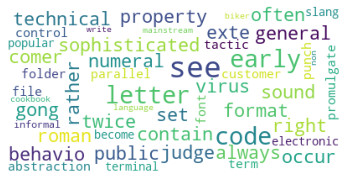


 The most frequent 50 words of book: Food and Flavor



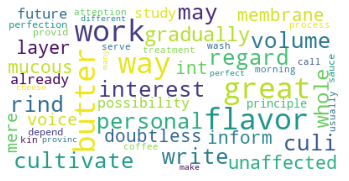


 The most frequent 50 words of book: Democracy In America



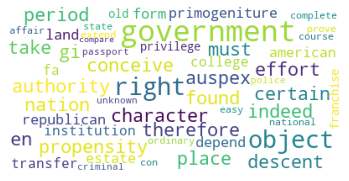


 The most frequent 50 words of book: The Lighter Classics in Music



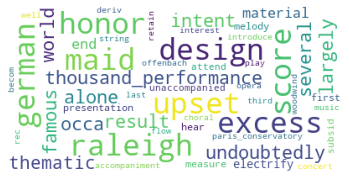


 The most frequent 50 words of book: The Common Law



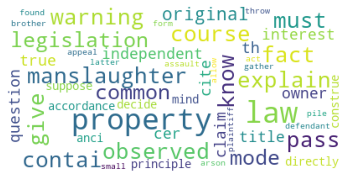

In [ ]:
# plot word cloud for the most frequent 50 words in each book  
import wordcloud

for label in data['title'].unique():
  books = data[data["title"]==label]["a150_Words"]

  #wordcloud 
  print(f"\n The most frequent 50 words of book: {label}\n")
  wc = wordcloud.WordCloud(background_color='white', max_words=50, 
                          max_font_size=35)
  wc = wc.generate(str(books))
  plt.axis('off')
  plt.imshow(wc, cmap=None)
  plt.show()

### (2) Visualize Predicted Clusters

In [ ]:
def visualize_cluster(cluster_model, data, y_pred, em=True):
  # get centroids of kmeans cluster
  if em:
    centroids = np.empty(shape=(cluster_model.n_components, data.shape[1]))
  else:
    centroids = cluster_model.cluster_centers_

  # we want to transform the rows and the centroids
  # todense return matrix
  matrix_data = csr_matrix(data)
  all_Data = concatenate((matrix_data.todense(), centroids))

  n_clusters = 5

  plt.scatter([all_Data[:-n_clusters, 0]], [all_Data[:-n_clusters, 1]], c=y_pred, cmap=plt.cm.Paired, marker= 'x')
  plt.scatter([all_Data[-n_clusters:, 0]], [all_Data[-n_clusters:, 1]], marker= 'o')
  plt.show()

#### (2.1) K-Means With BOW

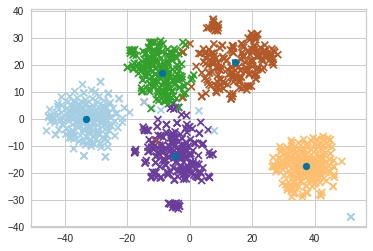

In [ ]:
visualize_cluster(bow_kmeans, bow_data, bow_kmeans_pred,False)

#### (2.2) K-Means With TFIDF

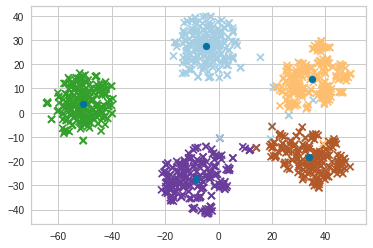

In [ ]:
visualize_cluster(tfidf_kmeans, tfidf_data, tfidf_kmeans_pred,False)

#### (2.3) K-Means With Word2Vec

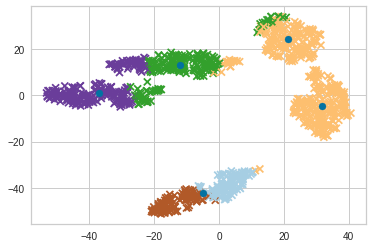

In [ ]:
visualize_cluster(emb_kmeans, emb_data, emb_kmeans_pred,False)

#### (2.4) K-Means With LDA

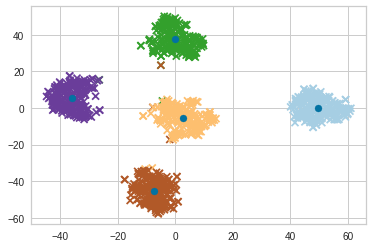

In [ ]:
visualize_cluster(lda_kmeans, lda_data, lda_kmeans_pred,False)

#### (3.1) EM With BOW

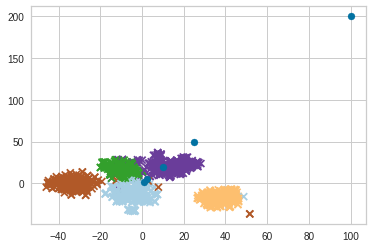

In [ ]:
visualize_cluster(bow_em, bow_data, bow_em_pred,True)

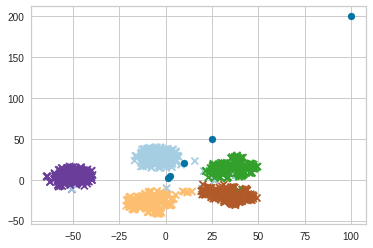

In [ ]:
visualize_cluster(tfidf_em, tfidf_data, tfidf_em_pred ,True)

In [ ]:
from collections import Counter
def cluster_count(pred):
  cls_count = Counter(pred)
  plt.bar(cls_count.keys(), cls_count.values())
# word2vec_count = Counter(emb_kmeans_pred)
# plt.bar(word2vec_count.keys(), word2vec_count.values())

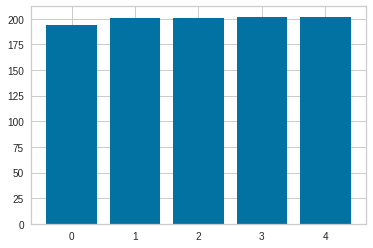

In [ ]:
cluster_count(bow_kmeans_pred)

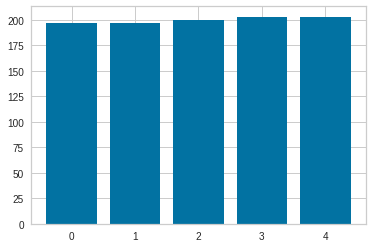

In [ ]:
cluster_count(tfidf_kmeans_pred)

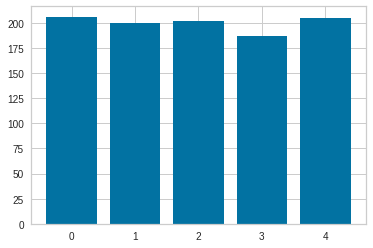

In [ ]:
cluster_count(emb_kmeans_pred)

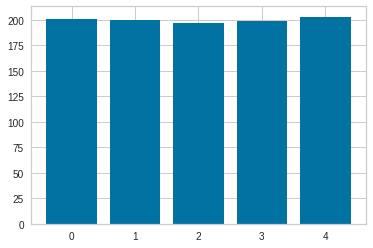

In [ ]:
cluster_count(lda_kmeans_pred)

# **`Error Analysis`**



For n_clusters = 3 The average silhouette_score is : 0.5637239 

For n_clusters = 4 The average silhouette_score is : 0.6675124 

For n_clusters = 5 The average silhouette_score is : 0.7577054 

For n_clusters = 6 The average silhouette_score is : 0.70844036 

For n_clusters = 7 The average silhouette_score is : 0.64306617 

For n_clusters = 8 The average silhouette_score is : 0.5641816 



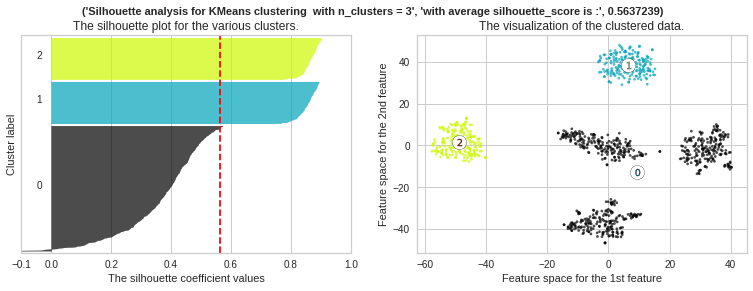

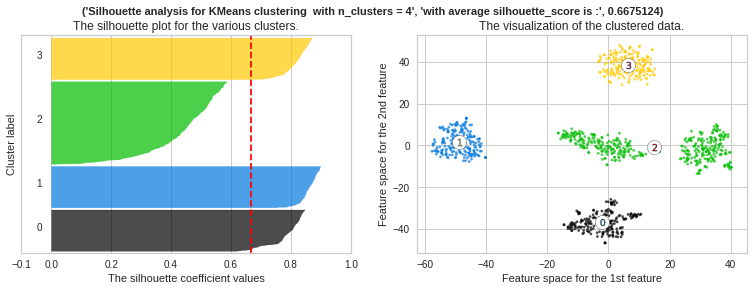

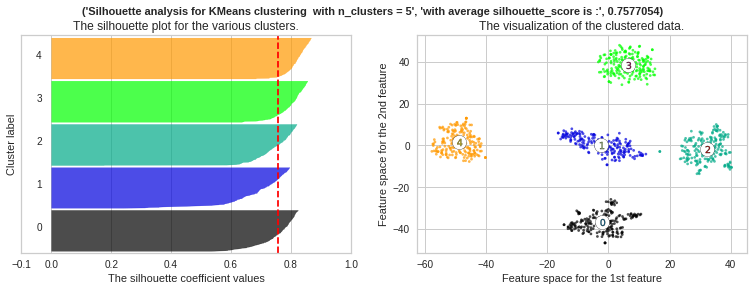

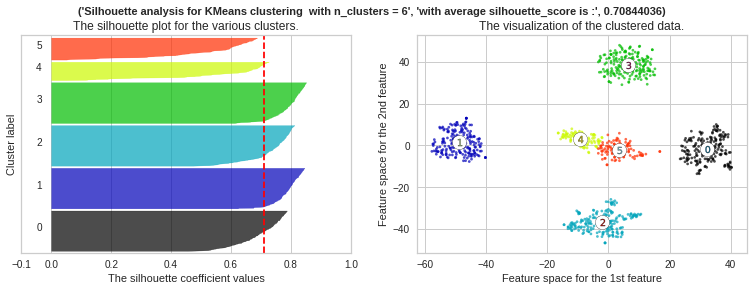

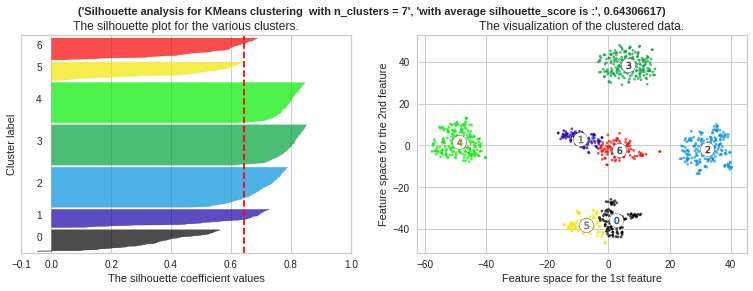

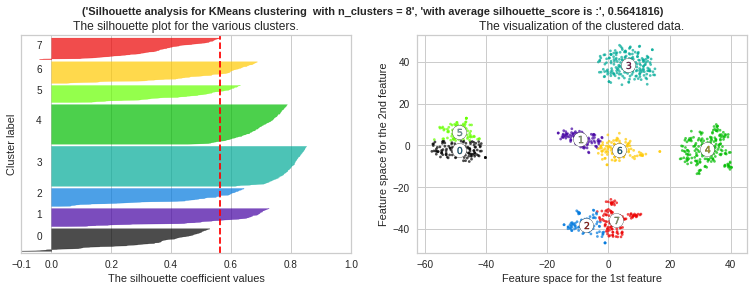

In [ ]:
# x_emb_matrix = csr_matrix(X_emb)
# centroids = emb_kmeans.cluster_centers_
# all_Data = concatenate((x_emb_matrix.todense(), centroids))
# tsne_init = "pca"
# tsne_perplexity = 30.0
# tsne_early_exaggeration = 4.0
# tsne_learning_rate = 10
# tsne_model = TSNE(n_components= 2,   # Dimension of the embedded space.
#                     random_state= 0,  
#                     init= tsne_init,
#                     perplexity= tsne_perplexity,
#                     early_exaggeration= tsne_early_exaggeration,
#                     learning_rate= tsne_learning_rate)
  
# transformed_labeled_Data = tsne_model.fit_transform(all_Data)
  
range_n_clusters = [ 3, 4, 5, 6,7,8]
sil_scores = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(13, 4)
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(lda_data) + (n_clusters + 1) * 10])
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(lda_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(lda_data, cluster_labels)
    sil_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg ,"\n")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(lda_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(lda_data[:, 0], lda_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering  "
                  "with n_clusters = %d" % n_clusters ,"with average silhouette_score is :", silhouette_avg ),
                 fontsize=11, fontweight='bold')

plt.show()

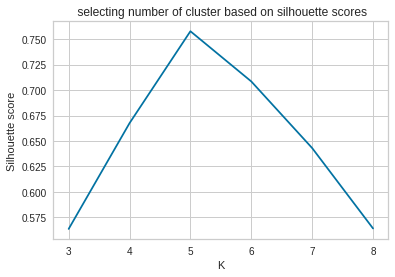

In [ ]:
plt.plot(range_n_clusters , sil_scores )
plt.title(" selecting number of cluster based on silhouette scores")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.show()

In [ ]:
# Create  analysis data frame 
def analysis_data (features_eng_results , data):
  analysis_df = data[['a150_Words', 'label' , "index" ]]
  analysis_df['cluster_output'] = pd.DataFrame(features_eng_results.astype(str))
  return analysis_df

In [ ]:
# count the number of matches between most frequent words in clusters and true labels
from collections import Counter

def most_frequent_words(num_words ,df_name , label_column , docu_column):
  genres = []
  for label in df_name[label_column].unique():
    genre = df_name[df_name[label_column]==label][docu_column]
    genres.append(genre)

  clusters_label= []
  for cls in range(len(genres)):
    lab = []
    for doc in genres[cls]:
      text = ""
      text += doc
      text += " "
      lab.append(text)
    clusters_label.append(lab)

  clusters_content = []
  for i in range(len(clusters_label)):
    whole_texts = ""
    for j in range(len(clusters_label[i])):
      whole_texts += clusters_label[i][j]
      whole_texts += " "
    clusters_content.append(whole_texts)

  most_frequent_words = []
  most_frequent_words_weights = []

  for ele in range(len(clusters_content)):
    word_list =[]
    weights_list = []
    string = clusters_content[ele]
    split_it = string.split()                # Pass the split_it list to instance of Counter class.
    Count = Counter(split_it)              # most_common() produces k frequently encountered input values and their respective counts.
    most_occur = Count.most_common(num_words)
    for tup in range(len(most_occur)): 
      fw =  most_occur[tup][0]
      weights = most_occur[tup][1]
      word_list.append(fw)
      weights_list.append(weights)

    most_frequent_words.append(word_list)
    most_frequent_words_weights.append(weights_list)

  return most_frequent_words , most_frequent_words_weights

In [ ]:
# Create  disctionary of matches 
def matches_dict(labels_mf , clusters_label_mf):
  lab_cls_match = {}
  for i in range(len(labels_mf)):
    scores_i = []
    for j in range(len(clusters_mf)):
      matches = len(set(labels_mf[i]) & set(clusters_mf[j]))
      scores_i.append(matches)
    lab_cls_match[i] = scores_i 
  return lab_cls_match

In [ ]:
# Create  disctionary of matches_weights
def weights_dict(labels_mf , clusters_label_mf ,clusters_mfw ):
  lab_cls_match_weights = {}
  for i in range(len(labels_mf)):
    scores_i = []
    for j in range(len(clusters_mfw)):
      matches = len(set(labels_mf[i]) & set(clusters_mf[j]))
      weight = sum(clusters_mfw[j][0:matches])
      scores_i.append(weight)
    lab_cls_match_weights[i] = scores_i 
  return lab_cls_match_weights

In [ ]:
#show list most frequent words and there weights
def most_frequent_words_weights(lbl_list , wgt_list):
  list_most_frequent_words_weights = []
  for i  in range(len(lbl_list)):
    lis = []
    for f, b in zip(lbl_list[i], wgt_list[i]):
      element = [f ,b]
      ele= tuple(element)
      lis.append(ele)
    list_most_frequent_words_weights.append(lis)   
  return list_most_frequent_words_weights

In [ ]:
analysis_df = analysis_data(lda_kmeans_pred , data)
analysis_df

In [ ]:
labels_mf , labels_mfw  = most_frequent_words (25, 
                                               analysis_df,
                                               "index",
                                               "a150_Words")

clusters_mf,clusters_mfw = most_frequent_words( 25,
                                               analysis_df,
                                               "cluster_output",
                                               "a150_Words")

lab_cls_match = matches_dict(labels_mf , clusters_mf)
lab_cls_match

In [ ]:
lab_cls_weights = weights_dict(labels_mf ,
                               clusters_mf ,
                               clusters_mfw)
lab_cls_weights

In [ ]:
frequent_elements_labels = most_frequent_words_weights(labels_mf,labels_mfw)
print("\n Frequent words with its occurancies through the aactual class (label) \n")
print("most frequent words in label : 0  \n ", frequent_elements_labels[0] ,"\n")
print("most frequent words in label : 1  \n ", frequent_elements_labels[1] ,"\n")
print("most frequent words in label : 2  \n ", frequent_elements_labels[2] ,"\n")
print("most frequent words in label : 3  \n ", frequent_elements_labels[3] ,"\n")
print("most frequent words in label : 4  \n ", frequent_elements_labels[4] ,"\n")

In [ ]:
frequent_elements_weights = most_frequent_words_weights(clusters_mf,clusters_mfw)
print("\n Frequent words with its occurancies through the aactual cluster (output) \n")
print("most frequent words in cluster : 0  \n ", frequent_elements_weights[0] ,"\n")
print("most frequent words in cluster : 1  \n ", frequent_elements_weights[1] ,"\n")
print("most frequent words in cluster : 2  \n ", frequent_elements_weights[2] ,"\n")
print("most frequent words in cluster : 3  \n ", frequent_elements_weights[3] ,"\n")
print("most frequent words in cluster : 4  \n ", frequent_elements_weights[4] ,"\n")